Import the libraries needed

In [1]:
import pandas as pd
import numpy as np
import os
import pyodbc
pyodbc.drivers()
from datetime import datetime
import psutil

# For the Yahoo Finance api
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')

C:\Users\m033\Anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
pd.set_option('max_row', None)
#pd.options.display.max_rows = 1000

# Set a value for the home folder.
home_folder = "."

# Set values for the various paths.
input_path = home_folder + "\data"

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-08-05 21:46:04.562979
svmem(total=16756752384, available=8852185088, percent=47.2, used=7904567296, free=8852185088)


### All the data used has been provisined in Get_The_Data.ipynb

# Investigated the spike and it is downw to a fund closure on those dates.

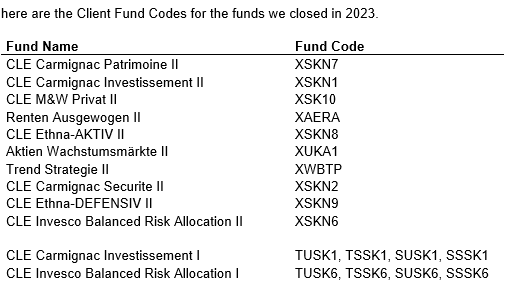

# 1. Read back the dataset of all switches.

In [5]:
# giving directory name
All_Switches = input_path + '\All_Switches.csv'

df_All_Switches = pd.read_csv(All_Switches, delimiter=',',low_memory=False, header=0)

# Filter out old dates.
df_All_Switches = df_All_Switches[df_All_Switches.PROCESSING_DATE > '20181231']

# Make the processing date a real date.
df_All_Switches['PROCESSING_DATE'] = pd.to_datetime(df_All_Switches['PROCESSING_DATE'])

# print stats.
print(len(df_All_Switches.index))
print(df_All_Switches.dtypes)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_All_Switches.head(5)

201805
index                              int64
POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
dtype: object
2024-08-05 21:46:49.928583
svmem(total=16756752384, available=10141782016, percent=39.5, used=6614970368, free=10141782016)


# 2. Create a new dataframe with switches for the fund close date range.

In [6]:
from_dt = '2022-04-01'
to_dt   = '2022-07-31'
df_Fund_Close_Period = df_All_Switches[(df_All_Switches['PROCESSING_DATE'] > from_dt) & (df_All_Switches['PROCESSING_DATE'] < to_dt)]

print(len(df_Fund_Close_Period.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Fund_Close_Period.head(5)

9893
2024-08-05 21:47:11.146118
svmem(total=16756752384, available=10128609280, percent=39.6, used=6628143104, free=10128609280)


# 3. Get a list of policies that were involved in a fund closure.

In [7]:
# These are the funds that were closed.
close_funds = ['XSKN7','XSKN1','XSK10','XAERA','XSKN8','XUKA1','XWBTP','XSKN2','XSKN9',
               'XSKN6','TUSK1','TSSK1','SUSK1','SSSK1','TUSK6','TSSK6','SUSK6','SSSK6']

print('These are the funds that were closed.',close_funds)

# Find the rows where this exists
df_Fund_Close_Pols = df_Fund_Close_Period[df_Fund_Close_Period.LEGACY_FUND_CODE.isin(close_funds)]


# Find the rows where this exists
#df_Fund_Close_Pols = df_Fund_Close_Period[~df_Fund_Close_Period.LEGACY_FUND_CODE.isin(close_funds)]
df_Fund_Close_Pols = df_Fund_Close_Period[df_Fund_Close_Period.LEGACY_FUND_CODE.isin(close_funds)]

# Isolate teh policy number
df_Fund_Close_Unique_Pols = df_Fund_Close_Pols[['POLICY_NUMBER']]

# Drop duplicate policy numbers
df_Fund_Close_Unique_Pols = df_Fund_Close_Unique_Pols.drop_duplicates(subset=['POLICY_NUMBER'], keep='first')

df_Fund_Close_Unique_Pols = df_Fund_Close_Unique_Pols.rename(columns={"POLICY_NUMBER":"Pols_To_Delete"})
df_Fund_Close_Unique_Pols.head(5)

# Write out to a comma separated values file.
filename = input_path + '\Fund_Close_Unique_Pols.csv'
df_Fund_Close_Unique_Pols.to_csv(filename, encoding='utf-8', index=False)  

print(len(df_Fund_Close_Unique_Pols.index))
print(filename)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Fund_Close_Unique_Pols.head(5)

These are the funds that were closed. ['XSKN7', 'XSKN1', 'XSK10', 'XAERA', 'XSKN8', 'XUKA1', 'XWBTP', 'XSKN2', 'XSKN9', 'XSKN6', 'TUSK1', 'TSSK1', 'SUSK1', 'SSSK1', 'TUSK6', 'TSSK6', 'SUSK6', 'SSSK6']
69
.\data\Fund_Close_Unique_Pols.csv
2024-08-05 21:47:17.450136
svmem(total=16756752384, available=10107330560, percent=39.7, used=6649421824, free=10107330560)


# 4. Using the policy numbers from the list of policies that were involved in a fund closure, create a list of switches to delete.

In [8]:
print(len(df_Fund_Close_Period.index))
print(len(df_Fund_Close_Unique_Pols.index))


9893
69


In [9]:
df_LEFT_A = pd.merge(df_Fund_Close_Period, df_Fund_Close_Unique_Pols, left_on = ['POLICY_NUMBER'], right_on = ['Pols_To_Delete'] , how = 'left') 
print(len(df_LEFT_A.index))

# Write out to a comma separated values file.
filename = input_path + '\df_LEFT_A.csv'
df_LEFT_A.to_csv(filename, encoding='utf-8', index=False)  

print(filename)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_LEFT_A.head(25)

9893
.\data\df_LEFT_A.csv
2024-08-05 21:47:27.880984
svmem(total=16756752384, available=10250813440, percent=38.8, used=6505938944, free=10250813440)


In [10]:
print(len(df_Fund_Close_Period.index))
print(len(df_Fund_Close_Unique_Pols.index))
print(len(df_LEFT_A.index))

9893
69
9893


# 5. Delete the fund closure switches.

In [11]:
# nOW DELETE ALL ROWS WHERE Pols_To_Delete is not NULL
print(len(df_LEFT_A.index))

9893


In [12]:
#df = df_LEFT_A[df_LEFT_A.Pols_To_Delete != 'NaN']
df_LEFT_A = df_LEFT_A[df_LEFT_A.Pols_To_Delete.isnull()]
print(len(df_LEFT_A.index))


6978


In [13]:
df_Closed_Funds_Policies_Removed = df_LEFT_A.drop(['index','Pols_To_Delete'],axis=1)
print(len(df_Closed_Funds_Policies_Removed.index))
print(len(df_LEFT_A.index))

6978
6978


In [14]:
#df = df_LEFT_A[df_LEFT_A.Pols_To_Delete != 'NaN']
#df_Closed_Funds_Policies_Removed = df_LEFT_A[df_LEFT_A.Pols_To_Delete.isnull()]
print(len(df_Closed_Funds_Policies_Removed.index))
print(len(df_LEFT_A.index))

6978
6978


In [15]:
# Write out to a comma separated values file.
filename = input_path + '\Closed_Funds_Policies_Removed.csv'
df_Closed_Funds_Policies_Removed.to_csv(filename, encoding='utf-8', index=False)  

print(len(df_Closed_Funds_Policies_Removed.index))
print(len(df_Fund_Close_Period.index))

print(filename)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Closed_Funds_Policies_Removed.head(25)

6978
9893
.\data\Closed_Funds_Policies_Removed.csv
2024-08-05 21:48:02.401505
svmem(total=16756752384, available=10197200896, percent=39.1, used=6559551488, free=10197200896)


# 6. Create a dataframe with all other dates, outside teh fund closure period.

In [16]:
# Create a dataframe with all other dates.
from_dt = '2022-04-01'
to_dt = '2022-07-31'
df_Fund_NON_Close_Period = df_All_Switches[(df_All_Switches['PROCESSING_DATE'] < from_dt) | (df_All_Switches['PROCESSING_DATE'] > to_dt)]


# Write out to a comma separated values file.
filename = input_path + '\Fund_NON_Close_Period.csv'
df_Fund_NON_Close_Period.to_csv(filename, encoding='utf-8', index=False)  

print(len(df_Fund_NON_Close_Period.index))

print(filename)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Fund_NON_Close_Period.head(5)

191863
.\data\Fund_NON_Close_Period.csv
2024-08-05 21:48:14.050540
svmem(total=16756752384, available=10235625472, percent=38.9, used=6521126912, free=10235625472)


# 7. Merge them back to get a dataframe that has the full set of switches, MINUS switches for policies involved in the fund closure.

In [17]:
# Merge the dataframes.
df_All_Switches_Without_Fund_Close= df_Closed_Funds_Policies_Removed.append(df_Fund_NON_Close_Period)
#df_Switches_Without_Fund_Close = df_Switches_Without_Fund_Close.drop(['Pols_To_Delete','level_0','index'],axis=1)


print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_All_Switches_Without_Fund_Close.head(5)

2024-08-05 21:48:27.133665
svmem(total=16756752384, available=10220535808, percent=39.0, used=6536216576, free=10220535808)


In [18]:
print("df_Fund_Close_Period             :",len(df_Fund_Close_Period.index))
print('df_Closed_Funds_Policies_Removed :',len(df_Closed_Funds_Policies_Removed.index))
print('df_Fund_NON_Close_Period         :',len(df_Fund_NON_Close_Period.index))
print('df_All_Switches                  :',len(df_All_Switches.index))


df_Fund_Close_Period             : 9893
df_Closed_Funds_Policies_Removed : 6978
df_Fund_NON_Close_Period         : 191863
df_All_Switches                  : 201805


In [19]:
df_All_Switches_Without_Fund_Close.dtypes

POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
index                            float64
dtype: object

# 8. Re-sort by policy number and processing date and write out file.

In [20]:
# Soryt by policy number and processing date.
#df_All_Switches_Without_Fund_Close = df_All_Switches_Without_Fund_Close.sort_values(['PROCESSING_DATE','POLICY_NUMBER','SOURCE']).reset_index(drop=False)
df_All_Switches_Without_Fund_Close = df_All_Switches_Without_Fund_Close.sort_values(['PROCESSING_DATE','POLICY_NUMBER','SOURCE'])

print(len(df_All_Switches_Without_Fund_Close.index))

# Write out to a comma separated values file.
filename = input_path + '\All_Switches_Without_Fund_Close.csv'
df_All_Switches_Without_Fund_Close.to_csv(filename, encoding='utf-8', index=False)      

print(filename)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_All_Switches_Without_Fund_Close.head(10)

198841


C:\Users\m033\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:2106: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


.\data\All_Switches_Without_Fund_Close.csv
2024-08-05 21:48:42.426494
svmem(total=16756752384, available=10215571456, percent=39.0, used=6541180928, free=10215571456)


# 9. Get the switchable funds/switch counts.

In [21]:
filename = input_path + '\Full_Population_Count.csv'
df_Full_Population_Count = pd.read_csv(filename, delimiter=',',low_memory=False, header=0)
print(len(df_Full_Population_Count.index))

print(filename)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Full_Population_Count.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\Full_Population_Count.csv'

# 10. Create the Fund Switch Count dataframe.

In [ ]:
df_All_Switches_Without_Fund_Close.dtypes

In [22]:
df_Switches_Count = df_All_Switches_Without_Fund_Close[['POLICY_NUMBER','PROCESSING_DATE']]
#df_All_Switches['PROCESSING_DATE'] = pd.to_datetime(df_All_Switches['PROCESSING_DATE'].str.strip(), format='%Y/%m/%d')
df_Switches_Count['ProcessingtDt'] = df_Switches_Count['PROCESSING_DATE'].dt.strftime('%Y%m')

# Drop obsolete columns.
#df_Switches_Count = df_All_Switches.drop(['LEGACY_FUND_CODE','PRODUCT','EFFECTIVE_DATE','UNIT_TYPE',
#                                          'CHARGE_TYPE','CASH_VALUE','RISK_COMMENCEMENT_DATE','Cover_End_Date',
#                                         'index','Servicing_Broker_Code','Issue_Date','Anniversary_Date','SOURCE',
#                                          'PROCESSING_DATE','level_0','Pols_To_Delete'],axis=1)

# Stats
print(len(df_Switches_Count.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Switches_Count.head(5)

198841
2024-08-05 21:48:51.862071
svmem(total=16756752384, available=10194132992, percent=39.2, used=6562619392, free=10194132992)


C:\Users\m033\AppData\Local\Temp\ipykernel_13760\315763259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Switches_Count['ProcessingtDt'] = df_Switches_Count['PROCESSING_DATE'].dt.strftime('%Y%m')


# 11. Drop duplicate policy numbers

In [23]:
# Drop duplicate policy numbers
df_Switches_Count = df_Switches_Count.drop_duplicates(subset=['POLICY_NUMBER','ProcessingtDt'], keep='first')
df_Switches_Count = df_Switches_Count.drop(['POLICY_NUMBER'],axis=1)

# print stats.
print(len(df_Switches_Count.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Switches_Count.head(5)

7738
2024-08-05 21:48:57.902424
svmem(total=16756752384, available=10193973248, percent=39.2, used=6562779136, free=10193973248)


In [24]:
# Reset teh index on count
df_Switches_Count=df_Switches_Count[['ProcessingtDt']].value_counts().reset_index(name='counts')

# Sort by ProcessingtDt
df_Switches_Count = df_Switches_Count.sort_values(by=['ProcessingtDt'])

print(len(df_Switches_Count.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Switches_Count.head(5)

67
2024-08-05 21:49:02.065527
svmem(total=16756752384, available=10169073664, percent=39.3, used=6587678720, free=10169073664)


In [25]:
df_All_Switches_Without_Fund_Close.dtypes

POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
index                            float64
dtype: object

## Create the Fund Switch Count dataframe.

In [26]:
df_All_Switches = df_All_Switches_Without_Fund_Close
#df_All_Switches['PROCESSING_DATE'] = pd.to_datetime(df_All_Switches['PROCESSING_DATE'].str.strip(), format='%Y/%m/%d')
df_All_Switches['ProcessingtDt'] = df_All_Switches['PROCESSING_DATE'].dt.strftime('%Y%m')

# Drop obsolete columns.
df_Switches_Count = df_All_Switches.drop(['POLICY_NUMBER','LEGACY_FUND_CODE','PRODUCT','EFFECTIVE_DATE','UNIT_TYPE',
                                          'CHARGE_TYPE','CASH_VALUE','RISK_COMMENCEMENT_DATE','Cover_End_Date',
                                         'index','Servicing_Broker_Code','Issue_Date','Anniversary_Date','SOURCE','PROCESSING_DATE'],axis=1)

# Reset teh index on count
df_Switches_Count=df_Switches_Count[['ProcessingtDt']].value_counts().reset_index(name='counts')

# Sort by ProcessingtDt
df_Switches_Count = df_Switches_Count.sort_values(by=['ProcessingtDt'])

print(len(df_Switches_Count.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Switches_Count.head(5)

67
2024-08-05 21:49:19.197588
svmem(total=16756752384, available=10142748672, percent=39.5, used=6614003712, free=10142748672)


## Now remove all instances of these policies in the close fund period.

In [43]:
print(len(df_Fund_Close_Period.index))
print(df_Fund_Close_Period.head(5))
print(df_Fund_Close_Period.tail(5))


# Write out to a comma separated values file.
filename = input_path + '\Fund_Close_Period.csv'
#df_Fund_Close_Period.to_csv(filename, encoding='utf-8', index=False)  

print(filename)

9893
       index POLICY_NUMBER LEGACY_FUND_CODE     PRODUCT PROCESSING_DATE  \
91377  90267      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91378  90268      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91379  90269      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91380  90270      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91381  90271      6141188W            SUDGB  XRP_2003V2      2022-04-04   

      EFFECTIVE_DATE UNIT_TYPE CHARGE_TYPE  CASH_VALUE RISK_COMMENCEMENT_DATE  \
91377     2022-03-31         A           B   6052.3908             2004-12-01   
91378     2022-03-31         A           B    175.2501             2004-12-01   
91379     2022-03-31         A           B    157.6735             2004-12-01   
91380     2022-03-31         A           B    142.0594             2004-12-01   
91381     2022-03-31         A           B    125.2194             2004-12-01   

      Servicing_Broker_Code  Issue_Date Cover_End_Date An

In [27]:
print(len(df_Fund_Close_Unique_Pols.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Fund_Close_Unique_Pols.head(5)

69
2024-08-05 21:49:43.669842
svmem(total=16756752384, available=10146836480, percent=39.4, used=6609915904, free=10146836480)


## Remove close fund pols from the full list from that period.

In [30]:
close_fund_pols = df_Fund_Close_Unique_Pols.values.tolist()

# Stata

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#close_fund_pols

2024-08-05 21:50:15.672614
svmem(total=16756752384, available=10113732608, percent=39.6, used=6643019776, free=10113732608)


In [31]:
df_Fund_Close_Period_New = df_Fund_Close_Period[df_Fund_Close_Period.POLICY_NUMBER.isin(close_fund_pols)]

print(len(df_Fund_Close_Period_New.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Fund_Close_Period_New.head(5)

0
2024-08-05 21:50:16.455240
svmem(total=16756752384, available=10107117568, percent=39.7, used=6649634816, free=10107117568)


In [33]:
print(len(df_Fund_Close_Period.index))

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# No displays to protect PII data
#df_Fund_Close_Period.head(5)

9893
2024-08-05 21:50:21.983638
svmem(total=16756752384, available=10121023488, percent=39.6, used=6635728896, free=10121023488)


In [34]:
%who_ls DataFrame 

['df_All_Switches',
 'df_All_Switches_Without_Fund_Close',
 'df_Closed_Funds_Policies_Removed',
 'df_Fund_Close_Period',
 'df_Fund_Close_Period_New',
 'df_Fund_Close_Pols',
 'df_Fund_Close_Unique_Pols',
 'df_Fund_NON_Close_Period',
 'df_LEFT_A',
 'df_Switches_Count']

In [35]:
del df_All_Switches
del df_All_Switches_Without_Fund_Close
del df_Closed_Funds_Policies_Removed
del df_Full_Population_Count
del df_Fund_Close_Period
del df_Fund_Close_Period_New
del df_Fund_Close_Pols
del df_Fund_Close_Unique_Pols
del df_Fund_NON_Close_Period
del df_LEFT_A
del df_Switches_Count

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

NameError: name 'df_Full_Population_Count' is not defined